# MovieLens Recommender - What to watch next?

With the rise of VOD services based on streaming technologies such as Disney+ or HBO, which populates the already crowded market led by Netflix, recommender systems became popular again, updating classic models such as the Collaborative Filtering with new technologies as Deep Learning.

In this notebook we will see how we can build a recommender system upon an *explicit* dataset, which

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

/Users/josualonso/miniforge3/envs/torch-gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

In [3]:
df = pd.read_csv('../data/ratings.csv')

In [4]:
df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
df.shape

(100004, 4)

## Data Analysis

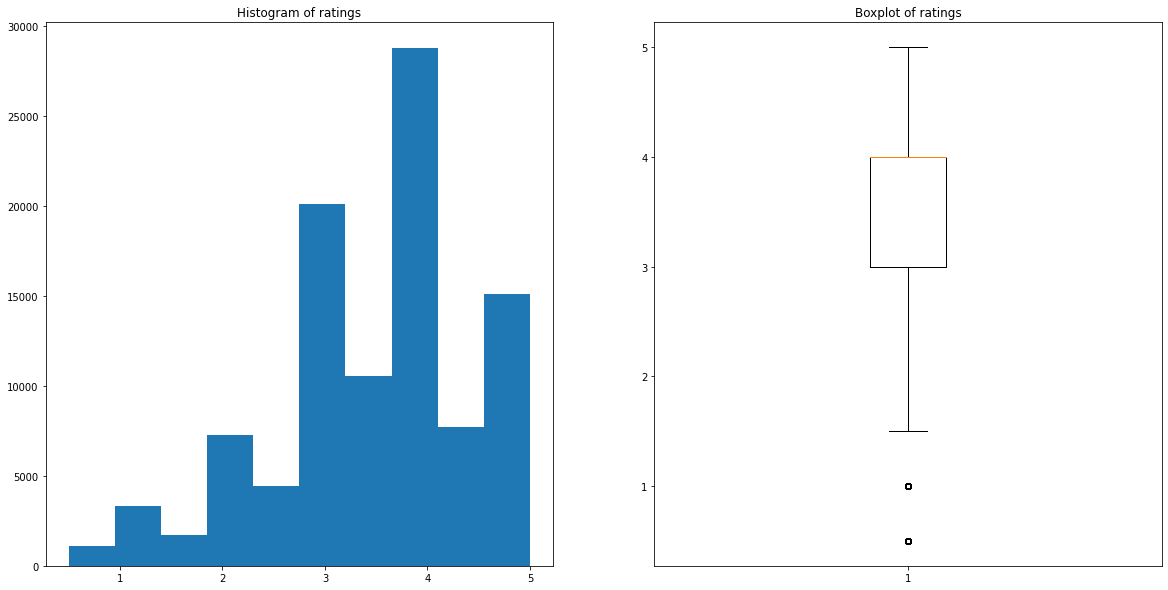

In [6]:
fig, ax = plt.subplots(figsize=(20, 10), ncols=2)
ax[0].hist(x=df.rating,)
ax[0].set_title("Histogram of ratings")
ax[1].boxplot(x=df.rating,)
ax[1].set_title("Boxplot of ratings")
plt.show()

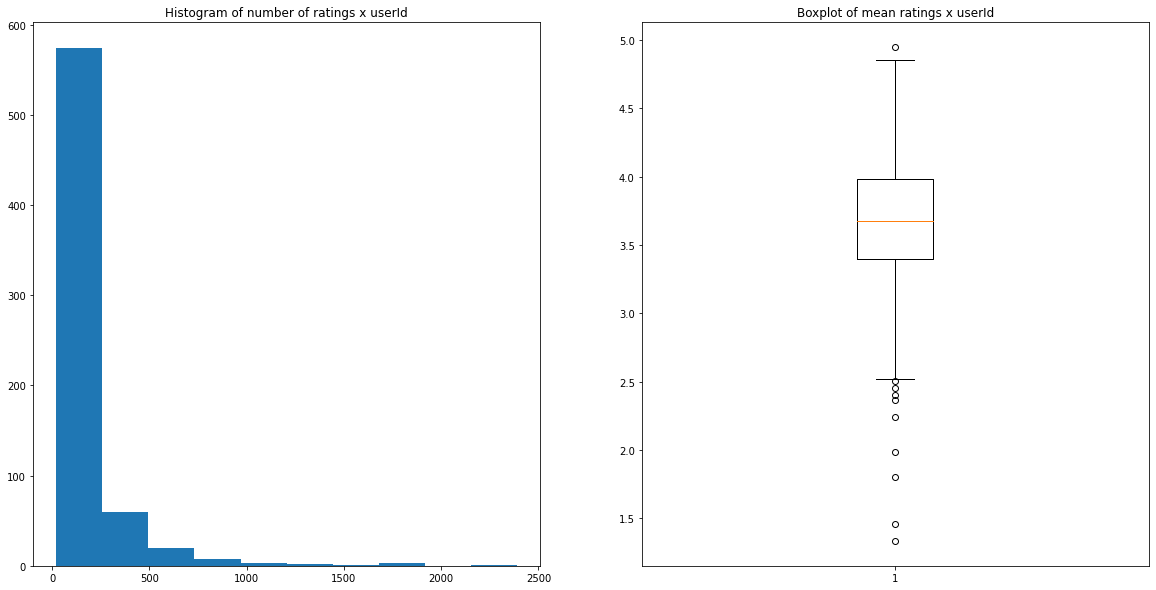

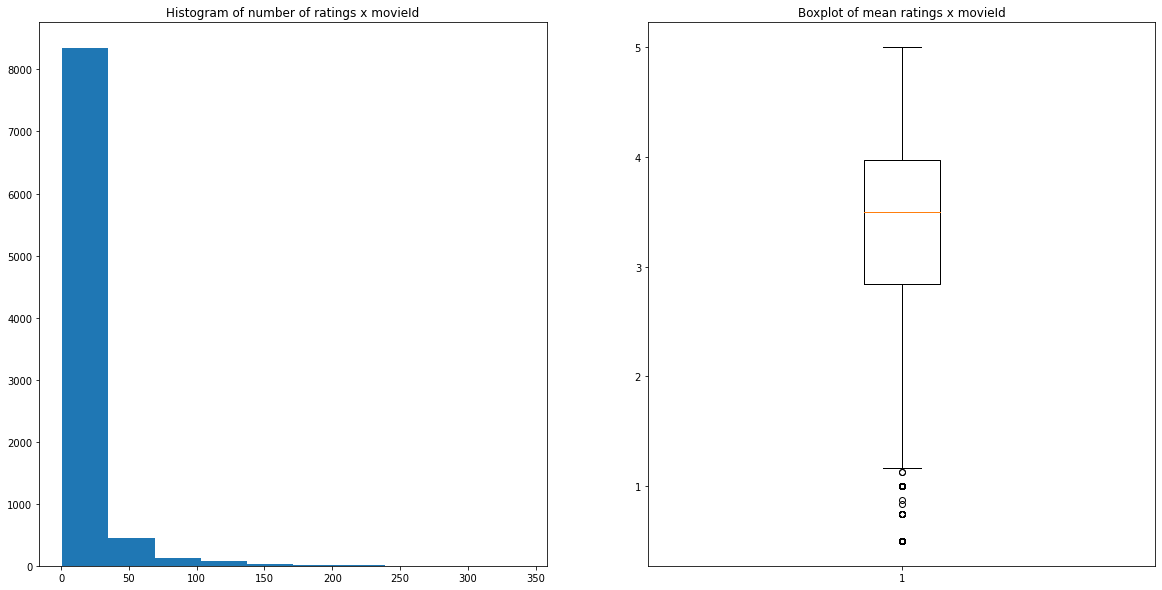

In [7]:
for column in ('userId', 'movieId'):
    grouped_ratings = df.groupby(column).agg(
        n_ratings=('rating', pd.Series.count),
        mean_rating=('rating', pd.Series.mean),
    )

    fig, ax = plt.subplots(figsize=(20, 10), ncols=2)
    ax[0].hist(x=grouped_ratings.n_ratings,)
    ax[0].set_title(f"Histogram of number of ratings x {column}")
    ax[1].boxplot(x=grouped_ratings.mean_rating,)
    ax[1].set_title(f"Boxplot of mean ratings x {column}")
    plt.show()

## Modelling

### Classic Collaborative Filtering

In [8]:
class ColabDataset(Dataset):
    def __init__(self, dataframe, device):
        self.x = torch.tensor(dataframe.iloc[:, :2].values, dtype=torch.int, device=device)
        self.y = torch.tensor(dataframe.iloc[:, 2].values, dtype=torch.float, device=device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]

In [9]:
class Recommender(nn.Module):
    def __init__(self, n_users, n_movies, emb_size, y_range):
        super(Recommender, self).__init__()
        self.user_embedding = nn.Embedding(n_users, emb_size)
        self.user_bias = nn.Embedding(n_users, 1)
        self.movie_embedding = nn.Embedding(n_movies, emb_size)
        self.movie_bias = nn.Embedding(n_movies, 1)
        self.y_range = torch.tensor([[y_range]], dtype=torch.float)

    def forward(self, x):
        users = self.user_embedding(x[:, 0])
        movies = self.movie_embedding(x[:, 1])
        result = (users * movies).sum(dim=1, keepdim=True)
        result += result + self.user_bias(x[:, 0]) + self.movie_bias(x[:, 1])
        return result.clip(min=y_range[0], max=y_range[1])

In [10]:
def train_model(model, loader, epochs, optimizer, criterion):
    model.train()
    for i in range(epochs):
        print(f"Starting epoch {i}...")
        for x, y in loader:
            y_hat = model(x)
            optimizer.zero_grad()
            loss = criterion(y_hat, y.unsqueeze(1))
            loss.backward()
            optimizer.step()
        print(f"Loss obtained: {loss.item()}")

In [11]:
def get_results(model, loader, criterion):
    for x, y in loader:
        y_hat = model(x)
        loss = criterion(y_hat, y.unsqueeze(1))
    print(f"Loss obtained: {loss}")
    return loss

In [12]:
device = 'cpu'
learning_rate = 0.001
batch_size = 256

In [13]:
df = df.sort_values(by='timestamp')
cutoff_index = int(df.shape[0] * 0.8)
df_train, df_test = df.iloc[:cutoff_index, :], df.iloc[cutoff_index:, :]

dataset_train = ColabDataset(df_train, device)
dataset_test = ColabDataset(df_test, device)

train_loader = DataLoader(
    dataset_train,
    batch_size,
)
test_loader = DataLoader(
    dataset_test,
    batch_size,
)

In [14]:
n_users = df.userId.max() + 1
n_movies = df.movieId.max() + 1
emb_size = 50
y_range = (0.5, 5)

model = Recommender(n_users, n_movies, emb_size, y_range)
model = model.to(device)

In [15]:
optimizer = optim.Adam(model.parameters(), learning_rate)
criterion = nn.MSELoss()

In [21]:
train_model(model, train_loader, 25, optimizer, criterion)

Starting epoch 0...
Loss obtained: 7.325753211975098
Starting epoch 1...
Loss obtained: 7.0859785079956055
Starting epoch 2...
Loss obtained: 7.035270690917969
Starting epoch 3...
Loss obtained: 7.01871919631958
Starting epoch 4...
Loss obtained: 7.005351543426514
Starting epoch 5...
Loss obtained: 7.0097856521606445
Starting epoch 6...
Loss obtained: 7.026294708251953
Starting epoch 7...
Loss obtained: 7.057973384857178
Starting epoch 8...
Loss obtained: 7.050586700439453
Starting epoch 9...
Loss obtained: 7.040704727172852


In [30]:
test_loss = get_results(model, test_loader, criterion)

Global Loss obtained: 7.813762187957764


### Feed-Forward Collaborative Network

In [41]:
class FFRecommender(nn.Module):
    def __init__(self, n_users, n_movies, emb_size, n_units, dropout, y_range):
        super(FFRecommender, self).__init__()
        self.user_embedding = nn.Embedding(n_users, emb_size)
        self.movie_embedding = nn.Embedding(n_movies, emb_size)
        self.linear1 = nn.Linear(emb_size * 2, n_units)
        self.linear2 = nn.Linear(n_units, 1)
        self.dropout = nn.Dropout(dropout)
        self.y_range = torch.tensor([[y_range]], dtype=torch.float)

    def forward(self, x):
        users = self.user_embedding(x[:, 0])
        movies = self.movie_embedding(x[:, 1])
        h1 = nn.functional.relu(self.linear1(torch.cat([users, movies], 1)))
        h1 = self.dropout(h1)
        result = self.linear2(h1)
        return result.clip(min=y_range[0], max=y_range[1])

In [44]:
n_units = 100
dropout = 0.2

ff_model = FFRecommender(n_users, n_movies, emb_size, n_units, dropout, y_range)
ff_model = ff_model.to(device)

optimizer = optim.Adam(ff_model.parameters(), learning_rate)
criterion = nn.MSELoss()

In [45]:
train_model(ff_model, train_loader, 25, optimizer, criterion)

Starting epoch 0...
Loss obtained: 1.5955442190170288
Starting epoch 1...
Loss obtained: 1.5499167442321777
Starting epoch 2...
Loss obtained: 1.2634353637695312
Starting epoch 3...
Loss obtained: 1.1901389360427856
Starting epoch 4...
Loss obtained: 1.2445697784423828
Starting epoch 5...
Loss obtained: 1.01384437084198
Starting epoch 6...
Loss obtained: 0.9811345338821411
Starting epoch 7...
Loss obtained: 0.9718248248100281
Starting epoch 8...
Loss obtained: 1.0227289199829102
Starting epoch 9...
Loss obtained: 0.9316130876541138
Starting epoch 10...
Loss obtained: 0.8406617641448975
Starting epoch 11...
Loss obtained: 0.8861462473869324
Starting epoch 12...
Loss obtained: 0.8151577711105347
Starting epoch 13...
Loss obtained: 0.8097875118255615
Starting epoch 14...
Loss obtained: 0.735407292842865
Starting epoch 15...
Loss obtained: 0.7782204151153564
Starting epoch 16...
Loss obtained: 0.7488981485366821
Starting epoch 17...
Loss obtained: 0.7999669313430786
Starting epoch 18...
Lo

In [75]:
test_loss = get_results(ff_model, test_loader, criterion)

Global Loss obtained: 0.9601640105247498


### Sequential Model

In [38]:
sequences = []
for userId in df_train.userId.unique():
    df_filtered = df[df['userId'] == userId].sort_values(by='timestamp')
    user_sequence = (df_filtered['movieId'].values[:10], df_filtered['rating'].values[:10])
    sequences.append(user_sequence)

cutoff_index = int(len(sequences) * 0.8)
sequences_train, sequences_test = sequences[:cutoff_index], sequences[cutoff_index:]

In [ ]:
class SeqRecommender(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_items, num_output):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.linear = nn.Linear(hidden_dim, num_output)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # initialize both hidden layers
        return (torch.autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
                torch.autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, sequence):
        embeddings = self.item_embeddings(sequence)
        output, self.hidden = self.lstm(embeddings.view(len(sequence), 1, -1),
                                        self.hidden)
        rating_scores = self.linear(output.view(len(sequence), -1))
        return rating_scores

    def predict(self, sequence):
        rating_scores = self.forward(sequence)
        return rating_scores

In [70]:
n_units_lstm = 30

seq_model = SeqRecommender(emb_size, n_units_lstm, n_movies, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(seq_model.parameters(), learning_rate)

seq_model.train()
for epoch in range(25):
    for sequence, target_ratings in sequences_train:
        seq_model.zero_grad()
        # initialize hidden layers
        seq_model.hidden = seq_model.init_hidden()
        # convert sequence to PyTorch variables
        sequence_var = torch.autograd.Variable(torch.LongTensor(sequence.astype('int64')))
        # forward pass
        ratings_scores = seq_model(sequence_var)
        target_ratings_var = torch.autograd.Variable(torch.FloatTensor(target_ratings.astype('float32')))
        # compute loss
        loss = criterion(ratings_scores, target_ratings_var.view(10, 1))
        # backpropagate
        loss.backward(retain_graph=True)
        # update weights
        optimizer.step()
    print(f"Loss obtained on epoch {epoch+1}: {loss.item()}")

Loss obtained on epoch 1: 1.6120145320892334
Loss obtained on epoch 2: 1.4184951782226562
Loss obtained on epoch 3: 1.17024827003479
Loss obtained on epoch 4: 1.0041344165802002
Loss obtained on epoch 5: 0.9770200848579407
Loss obtained on epoch 6: 1.0121451616287231
Loss obtained on epoch 7: 1.1190639734268188
Loss obtained on epoch 8: 1.2192742824554443
Loss obtained on epoch 9: 1.2514474391937256
Loss obtained on epoch 10: 1.2087265253067017
Loss obtained on epoch 11: 1.154654860496521
Loss obtained on epoch 12: 1.0692048072814941
Loss obtained on epoch 13: 1.0285985469818115
Loss obtained on epoch 14: 0.9221988916397095
Loss obtained on epoch 15: 0.8521041870117188
Loss obtained on epoch 16: 0.7930628061294556
Loss obtained on epoch 17: 0.7057464718818665
Loss obtained on epoch 18: 0.7401238083839417
Loss obtained on epoch 19: 0.5769805312156677
Loss obtained on epoch 20: 0.5559548735618591
Loss obtained on epoch 21: 0.4918745458126068
Loss obtained on epoch 22: 0.4267632067203522


In [72]:
for sequence, target_ratings in sequences_test:
    sequence_var = torch.autograd.Variable(torch.LongTensor(sequence.astype('int64')))
    ratings_scores = seq_model(sequence_var)
    target_ratings_var = torch.autograd.Variable(torch.FloatTensor(target_ratings.astype('float32')))
    loss = criterion(ratings_scores, target_ratings_var.view(10, 1))
print(f"Loss obtained: {loss}")

Loss obtained: 0.7846352458000183
